   ### **pip指令**

In [ ]:
pip install --upgrade keras


Note: you may need to restart the kernel to use updated packages.


### 停用警告

In [2]:
import warnings

# 禁用所有警告
warnings.filterwarnings('ignore')

### 下載股票數據&數據處理

In [3]:
import numpy as np
import datetime
import yfinance as yf

stock_number = '0050.TW'
start = datetime.datetime(2000, 1, 1)

end = datetime.datetime(2024, 1, 16)

df = yf.download(stock_number, start=start, end=end)

############################################################################
def Stock_Price_LSTM_Data_Preprocessing(df, mem_his_days, pre_days):
    
    
    df.dropna(inplace=True)
    df.sort_index(inplace=True)
    
    df['label'] = df['Close'].shift(-pre_days) # up-shift for pre-days
    #print(df['label'])
    #df.fillna(0,inplace=True)
    
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    sca_X = scaler.fit_transform(df.iloc[:, :-1])

    from collections import deque
    deq = deque(maxlen=mem_his_days)

    X = []
    for i in sca_X: 
        deq.append(list(i))
        if len(deq) == mem_his_days:
            X.append(list(deq))

    X_lately = X[-pre_days:]
    X = X[:-pre_days]

    y = df['label'].values[mem_his_days-1:-pre_days]


    X = np.array(X)
    y = np.array(y)
    
    
    
    return X, y, X_lately

df_copy=df
X, y, X_lately = Stock_Price_LSTM_Data_Preprocessing(df, 25, 5)
#print(y)
df=df_copy
X, y, X_lately = Stock_Price_LSTM_Data_Preprocessing(df.drop(columns=['label']), 25, 3)
#print(y)
print(df)
print(len(X))
print(len(y))
print(len(X_lately))


[*********************100%***********************]  1 of 1 completed


Price                       Adj Close       Close        High         Low  \
Ticker                        0050.TW     0050.TW     0050.TW     0050.TW   
Date                                                                        
2008-01-02 00:00:00+00:00   42.407539   60.009998   60.009998   60.009998   
2008-01-03 00:00:00+00:00   41.616070   58.889999   58.889999   58.889999   
2008-01-04 00:00:00+00:00   41.700874   59.009998   59.009998   59.009998   
2008-01-07 00:00:00+00:00   39.849380   56.389999   56.389999   56.389999   
2008-01-08 00:00:00+00:00   40.266312   56.980000   56.980000   56.980000   
...                               ...         ...         ...         ...   
2024-01-09 00:00:00+00:00  129.308487  133.000000  133.949997  132.750000   
2024-01-10 00:00:00+00:00  128.627914  132.300003  132.649994  132.000000   
2024-01-11 00:00:00+00:00  129.162659  132.850006  133.250000  132.350006   
2024-01-12 00:00:00+00:00  128.968201  132.649994  133.050003  131.949997   

### 模型超參數調整&訓練


In [4]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

lr_schedule = ExponentialDecay(initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.9)

'''
pre_days = [5, 10, 15, 20, 25, 30]
mem_days = [5, 10, 15, 20, 25, 30]
lstm_layers = [1, 2, 3, 4, 5]
dense_layers = [1, 2, 3, 4, 5]
units = [16, 32, 64]
'''
#fix the hyperparameter (沒有gpu QQ 有在考慮升級了)
pre_days = [5]
mem_days = [25]
lstm_layers = [2]
dense_layers = [5]
units = [64]


for the_pre_days in pre_days:
    for the_mem_days in mem_days:
        for the_lstm_layers in lstm_layers:
            for the_dense_layers in dense_layers:
                for the_units in units:
                    filepath = f'./models/{{val_mape:.2f}}_{{epoch:02d}}_pre_{the_pre_days}_men_{the_mem_days}_lstm_{the_lstm_layers}_dense_{the_dense_layers}_unit_{the_units}.weights.h5'

                    checkpoint = ModelCheckpoint(
                        filepath=filepath,
                        #save_weights_only初訓練設定true只保存值無法讀檔
                        save_weights_only=True,
                        monitor='val_mape',
                        mode='min',
                        save_best_only=True)
                    X, y, X_lately = Stock_Price_LSTM_Data_Preprocessing(df.drop(columns=['label']), the_mem_days, the_pre_days)
                    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)
                    
                    print(y)

                    model = Sequential()
                    model.add(LSTM(the_units, input_shape=X.shape[1:], return_sequences=True))
                    model.add(BatchNormalization())
                    model.add(Activation('sigmoid'))
                    model.add(Dropout(0.1))

                    for i in range(the_lstm_layers):
                        model.add(LSTM(the_units, return_sequences=True))
                        model.add(BatchNormalization())
                        model.add(Activation('sigmoid'))
                        model.add(Dropout(0.1))

                    model.add(LSTM(the_units))
                    model.add(BatchNormalization())
                    model.add(Activation('sigmoid'))
                    model.add(Dropout(0.1))

                    for i in range(the_dense_layers):
                        model.add(Dense(the_units))
                        model.add(BatchNormalization())
                        model.add(Activation('sigmoid'))
                        model.add(Dropout(0.1))

                    model.add(Dense(1))

                    # 使用自定義的學習率
                    model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='mse', metrics=['mape'])
                    #model.compile(optimizer='adam', loss='mse', metrics=['mape'])
                    model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), callbacks=[checkpoint])
                    
                    

[ 57.16999817  58.54999924  58.75999832 ... 132.8500061  132.6499939
 132.6499939 ]
Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - loss: 4357.8789 - mape: 83.8818 - val_loss: 11011.3760 - val_mape: 86.8570
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 668.1815 - mape: 22.9268 - val_loss: 814.9753 - val_mape: 22.2501
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 222.2643 - mape: 11.7169 - val_loss: 1218.0192 - val_mape: 27.8598
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 166.5585 - mape: 11.0373 - val_loss: 1013.7101 - val_mape: 25.3902
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 128.3599 - mape: 10.5945 - val_loss: 843.8091 - val_mape: 23.1937
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 103.7999 - mape: 9.9477 - val_loss: 3378.6523 - val_mape: 47.4969
Epoch 7/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 95.8325 - mape: 9.8687 - val_loss: 60.8859 - val_mape: 5.4865
Epoch 8/50
111/111 ━━━━━━

###  LSTM 模型的超參數最佳解產生

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

lr_schedule = ExponentialDecay(initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.9)

pre_days = [5]  
mem_days = [25]
lstm_layers = [2]
dense_layers = [5]
units = [64]

for the_pre_days in pre_days:
    for the_mem_days in mem_days:
        for the_lstm_layers in lstm_layers:
            for the_dense_layers in dense_layers:
                for the_units in units:
                    filepath = f'./models/{{val_mape:.2f}}_{{epoch:02d}}_pre_{the_pre_days}_men_{the_mem_days}_lstm_{the_lstm_layers}_dense_{the_dense_layers}_unit_{the_units}.keras'


                    checkpoint = ModelCheckpoint(
                        filepath=filepath,
                        #save_weights_only二次訓練設定false才能讀擋
                        save_weights_only=False,
                        monitor='val_mape',
                        mode='min',
                        save_best_only=True)

                    X, y, X_lately = Stock_Price_LSTM_Data_Preprocessing(df.drop(columns=['label']), the_mem_days, the_pre_days)   
                    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)

                    model = Sequential()
                    model.add(LSTM(the_units, input_shape=X.shape[1:], return_sequences=True))
                    model.add(BatchNormalization())
                    model.add(Activation('sigmoid'))
                    model.add(Dropout(0.1))

                    for i in range(the_lstm_layers):
                        model.add(LSTM(the_units, return_sequences=True))
                        model.add(BatchNormalization())
                        model.add(Activation('sigmoid'))
                        model.add(Dropout(0.1))

                    model.add(LSTM(the_units))
                    model.add(BatchNormalization())
                    model.add(Activation('sigmoid'))
                    model.add(Dropout(0.1))

                    for i in range(the_dense_layers):
                        model.add(Dense(the_units))
                        model.add(BatchNormalization())
                        model.add(Activation('sigmoid'))
                        model.add(Dropout(0.1))

                    model.add(Dense(1))

                    # 使用自定義的學習率
                    model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='mse', metrics=['mape'])

                    model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), callbacks=[checkpoint])


Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - loss: 3840.7405 - mape: 80.3478 - val_loss: 1169.4728 - val_mape: 27.3172
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 121.6317 - mape: 11.6634 - val_loss: 1661.2554 - val_mape: 33.0129
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 102.1023 - mape: 10.7399 - val_loss: 722.2868 - val_mape: 22.2282
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 112.5989 - mape: 11.1498 - val_loss: 1026.8390 - val_mape: 25.9543
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 82.0350 - mape: 9.9075 - val_loss: 700.3520 - val_mape: 21.5894
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 77.0643 - mape: 9.7535 - val_loss: 730.5457 - val_mape: 21.2706
Epoch 7/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 77.5849 - mape: 9.6627 - val_loss: 451.0044 - val_mape: 16.9318
Epoch 8/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 80.2905 - mape: 10.0272 - val_loss: 713.9740 - val_

### 尋找模型檔案


In [6]:
import os

# 確定當前工作目錄
current_directory = os.getcwd()  # %pwd 這個是 Jupyter Notebook 內建的魔術指令，如果在其他 IDE 中需要替換成 os.getcwd()

# 指定檔案路徑
folder_path = os.path.join(current_directory, 'models')

# 列出該資料夾下的所有檔案
files = os.listdir(folder_path)

# 過濾出以 '.h5' 結尾的檔案
model_files = [file for file in files if file.endswith('_pre_5_men_25_lstm_2_dense_5_unit_64.keras')]

# 輸出所有模型檔案
print("找到的模型檔案：")
for model_file in model_files:
    print(os.path.join(folder_path, model_file))



找到的模型檔案：
c:\Users\USER\Documents\GitHub\GDG_MLInvest\models\16.93_07_pre_5_men_25_lstm_2_dense_5_unit_64.keras
c:\Users\USER\Documents\GitHub\GDG_MLInvest\models\21.27_06_pre_5_men_25_lstm_2_dense_5_unit_64.keras
c:\Users\USER\Documents\GitHub\GDG_MLInvest\models\21.59_05_pre_5_men_25_lstm_2_dense_5_unit_64.keras
c:\Users\USER\Documents\GitHub\GDG_MLInvest\models\22.23_03_pre_5_men_25_lstm_2_dense_5_unit_64.keras
c:\Users\USER\Documents\GitHub\GDG_MLInvest\models\27.32_01_pre_5_men_25_lstm_2_dense_5_unit_64.keras
c:\Users\USER\Documents\GitHub\GDG_MLInvest\models\4.34_26_pre_5_men_25_lstm_2_dense_5_unit_64.keras
c:\Users\USER\Documents\GitHub\GDG_MLInvest\models\5.65_22_pre_5_men_25_lstm_2_dense_5_unit_64.keras
c:\Users\USER\Documents\GitHub\GDG_MLInvest\models\6.19_09_pre_5_men_25_lstm_2_dense_5_unit_64.keras


### 載入&評估模型

In [8]:
from tensorflow.keras.models import load_model

# 提供最佳模型的檔案路徑
filepath = r'./models/6.19_09_pre_5_men_25_lstm_2_dense_5_unit_64.keras'

# 定義任何自定義的層或函數
custom_objects = {
    # 如果有自定義的層或函數，請在這裡添加
}

# 載入模型
best_model = load_model(filepath, custom_objects=custom_objects)

# 顯示模型摘要
best_model.summary()

# 評估模型表現
best_model.evaluate(X_test, y_test)

# 預測結果
pre = best_model.predict(X_test)
print(len(pre))

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 25, 64)         │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 25, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 25, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 25, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 25, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 25, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 418,948 (1.60 MB)

 Trainable params: 139,265 (544.00 KB)

 Non-trainable params: 1,152 (4.50 KB)

 Optimizer params: 278,531 (1.06 MB)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 105.3187 - mape: 7.8738
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step
392


### 輸出視覺化結果


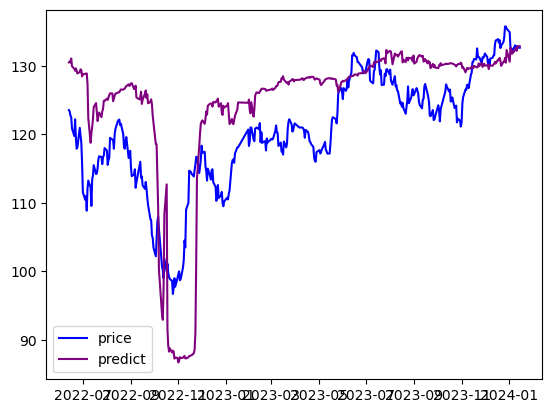

In [9]:
import matplotlib.pyplot as plt

# 繪製測試集與預測結果的對比圖
df_time = df.index[-len(y_test):]  # df_time 是與 y_test 相對應的時間軸
plt.plot(df_time, y_test, color='blue', label='price')
plt.plot(df_time, pre, color='purple', label='predict')
plt.legend()
plt.show()